### Set seed and set up environment

In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

### Import libraries and dependencies

In [ ]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import multiprocessing as mp
import math

# tensorflow libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [ ]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user()
drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
os.chdir("/drive/My Drive/ntu academia/cs y3/cz4042 NN/assignment")

### Read and Process Data

In [ ]:
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
def dataframe_to_dataset(dataframe):
    """
    Converts pandas DataFrame object to tensorflow Dataset object.

        Parameters: 
            dataframe (DataFrame): Dataframe containing input and output data
   
        Returns:
            ds (Dataset): Dataset containing input and output data
    """
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

def encode_numerical_feature(feature, name, dataset):
    """
    Encodes numerical features using Normalization and converts to Dataset object.

        Parameters: 
            feature (Tensor): Keras tensor initialized for numerical input feature
            name (str): Name of numerical input feature
            dataset (Dataset): Dataset containing all input and output data

        Returns:
            encoded_feature (Dataset): Dataset containing normalized numerical input feature data
    """
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    """
    One-hot encodes categorical features using StringLookup or IntegerLookup and converts to Dataset object.

        Parameters: 
            feature (Tensor): Keras tensor initialized for categorical input feature
            name (str): Name of categorical input feature
            dataset (Dataset): Dataset containing all input and output data
            is_string (bool): True if input feature is of dtype str, False otherwise
        
        Returns:
            encoded_feature (Dataset): Dataset containing categorical input feature data
    """
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# QUESTION 1

**1a) Divide the dataset into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 used as test data). Why is this done instead of random train/test splits?**

In [ ]:
# Split data into train and test sets based on year
train_dataframe = df[df['year'] <= 2020].copy() 
val_dataframe = df[df['year'] > 2020].copy()

# Drop columns not needed
train_dataframe.drop(['year', 'full_address', 'nearest_stn'], axis=1, inplace=True)
val_dataframe.drop(['year', 'full_address', 'nearest_stn'], axis=1, inplace=True)

# Generate tf.data.Dataset objects from dataframe
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

# Batch the datasets into batches of 128
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

Since we are training our neural network on historical data from 2020 and before, then testing on data from 2021, we are essentially evaluating our model's performance by how well it can learn to predict future resale price, given the training data from previous years. By doing so, we can better ensure the model converges towards being able to more accurately predict future resale price using historical data.

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded as strings
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")

# Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

# Concatenate input features
all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)

**1b) Following this tutorial, design a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer. One-hot encoding should be applied
to categorical features and numeric features are standardised. After
encoding / standardisation, the input features should be concatenated.**

### Build 2-layer feedforward network 

In [ ]:
# Build feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

**1c) On the training data, train the model for 100 epochs using mini-batch
gradient descent with batch size = 128, Use ‘adam’ optimiser with a
learning rate of 𝛼 = 0.05 and mean square error as cost function.**

### Create a custom metric for computing R-squared

In [ ]:
from keras import backend

def r_squared(y_true, y_pred):
  """
  Returns R-squared metric from actual and predicted target values.

      Parameters: 
          y_true (Tensor): Keras tensor containing actual target values
          y_pred (Tensor): Keras tensor containing predicted target values
          
      Returns:
          result (float): R-squared value computed using formula for R-squared
  """
  mean = backend.mean(y_true)
  num = backend.sum(backend.square(y_true - y_pred))
  denom = backend.sum(backend.square(y_true - mean))
  result = 1 - (num/denom)
  
  return result

### Compile model

In [ ]:
# Set parameters
batch_size = 128
no_epochs = 100
lr = 0.05

# Initialize optimizer
opt = keras.optimizers.Adam(learning_rate=lr)

# Compile model
model = keras.Model(all_inputs, output)
model.compile(optimizer=opt, 
              loss="mse",
              metrics=["mse", r_squared])

### Visualize connectivity graph

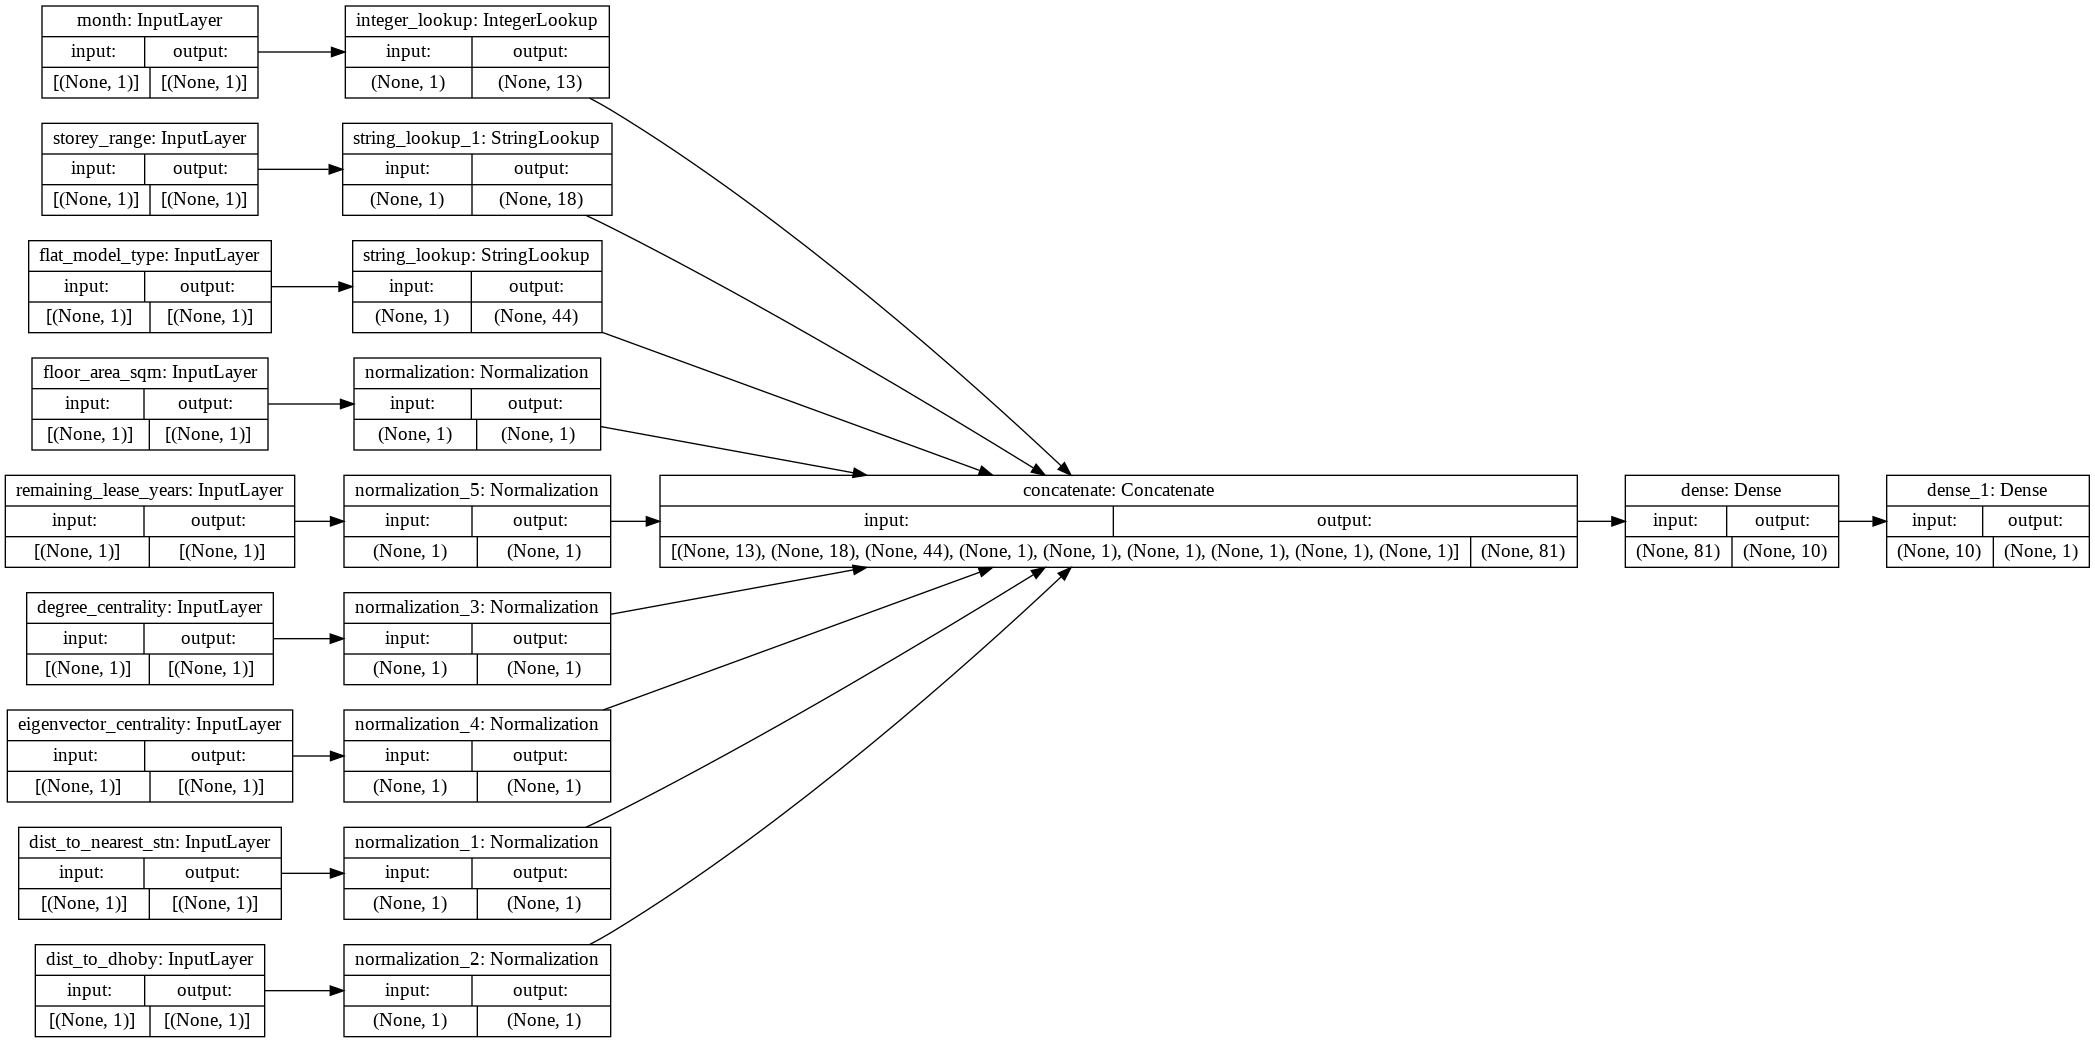

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Create callback to restore best model weights

In [ ]:
checkpoint_filepath = os.getcwd()

restore_weight_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

### Train the model

In [ ]:
history = model.fit(train_ds,
          epochs=no_epochs,
          batch_size=batch_size,
          callbacks=[restore_weight_callback],
          validation_data=val_ds)

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 187177730048.0000 - mse: 187177730048.0000 - r_squared: -7.0489 - val_loss: 170675044352.0000 - val_mse: 170675044352.0000 - val_r_squared: -5.6966
Epoch 2/100
683/683 [==============================] - 2s 3ms/step - loss: 67174182912.0000 - mse: 67174182912.0000 - r_squared: -1.8796 - val_loss: 39814365184.0000 - val_mse: 39814365184.0000 - val_r_squared: -0.5503
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 10811350016.0000 - mse: 10811350016.0000 - r_squared: 0.5418 - val_loss: 11000289280.0000 - val_mse: 11000289280.0000 - val_r_squared: 0.5751
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 5528955392.0000 - mse: 5528955392.0000 - r_squared: 0.7649 - val_loss: 8578768384.0000 - val_mse: 8578768384.0000 - val_r_squared: 0.6688
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4995456512.0000 - mse: 4995456512.0000 - r_squared: 0

**1d) Plot the train and test root mean square errors (RMSE) against epochs.**

In [ ]:
# Find root mean square error from model output
train_rmse = np.sqrt(history.history['mse'])
test_rmse = np.sqrt(history.history['val_mse'])

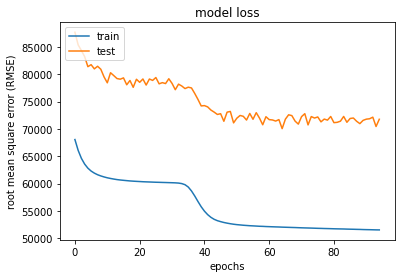

In [ ]:
# Skip first 5 epochs when plotting
plt.plot(train_rmse[5:])
plt.plot(test_rmse[5:])
plt.title('model loss')
plt.ylabel('root mean square error (RMSE)')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

**1e) State the epoch with the lowest test error. State the test R squared value at that epoch.**

In [ ]:
lowest_test_error = min(history.history['val_mse'])
epoch_lowest_error = history.history['val_mse'].index(lowest_test_error) + 1
print("Epoch with lowest test error: \t\t", epoch_lowest_error)
print("Test Mean-squared error at this epoch: \t", lowest_test_error)
print("Test RMSE at this epoch: \t\t", np.sqrt(lowest_test_error))
print("Test R-squared value at this epoch: \t", history.history["val_r_squared"][epoch_lowest_error-1])

Epoch with lowest test error: 		 70
Test Mean-squared error at this epoch: 	 4906419200.0
Test RMSE at this epoch: 		 70045.83642158897
Test R-squared value at this epoch: 	 0.8073545098304749


Epoch with lowest test error: Epoch 70

Test Mean-squared Error at this epoch: 4906419200.0

Test RMSE at this epoch: 70045.8364

Test R-squared value at this epoch: 0.8074

**1f) Using the model from that best epoch, plot the predicted values and
target values for a batch of 128 test samples. (Hint: Use a callback to
restore the best model weights. Find out how to retrieve a batch from
tf.BatchDataset. A scatter plot will suffice.)**

In [ ]:
model = model.load_weights(checkpoint_filepath)

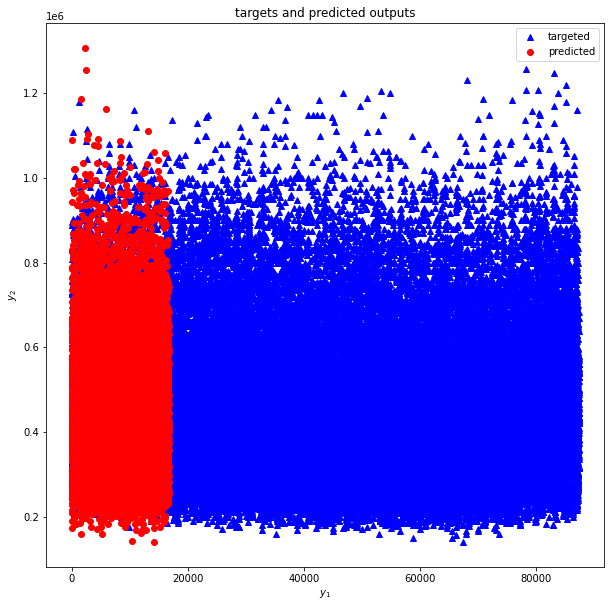

In [ ]:
# plot trained and predicted points
y_ = model.predict(val_ds)
    
plt.figure(1, figsize=(10,10))
plot_targets = plt.plot(train_dataframe["resale_price"], 'b^', label='targeted')
plot_pred = plt.plot(y_, 'ro', label='predicted')
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.title('targets and predicted outputs')
plt.legend()

# QUESTION 2

**2a)  Add an Embedding layer with output_dim = floor(num_categories/2)
after the one-hot embeddings for categorical variables. (Hint: Use the
tf.keras.layers.Embedding() later. Read the documentation carefully to
ensure that you define the correct function parameters4
.)**

In [ ]:
def encode_categorical_feature(feature, name, dataset, is_string):
    """
    Encodes categorical features using StringLookup or IntegerLookup and converts to Dataset object.

        Parameters: 
            feature (Tensor): Keras tensor initialized for categorical input feature
            name (str): Name of categorical input feature
            dataset (Dataset): Dataset containing all input and output data
            is_string (bool): True if input feature is of dtype str, False otherwise
        
        Returns:
            encoded_feature (Dataset): Dataset containing categorical input feature data
    """
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(data=feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

### Prepare dataset

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")

# Create Embedding layer for month
num_categories = len(np.unique(df["month"]))
embedding_size = math.floor(num_categories/2)
month_embedded = Embedding(input_dim=num_categories+1, output_dim=embedding_size)(month)
flatten_month_emb = Flatten()(month_embedded)

# Create Embedding layer for flat_model_type
num_categories = len(np.unique(df["flat_model_type"]))
embedding_size = math.floor(num_categories/2)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_embedded = Embedding(input_dim=num_categories+1, output_dim=embedding_size)(flat_model_type_encoded)
flatten_fmt_emb = Flatten()(flat_model_type_embedded)

# Create Embedding layer for storey_range
num_categories = len(np.unique(df["storey_range"]))
embedding_size = math.floor(num_categories/2)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
storey_range_embedded = Embedding(input_dim=num_categories+1, output_dim=embedding_size)(storey_range_encoded)
flatten_sr_emb = Flatten()(storey_range_embedded)

# Numerical features
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

# Concatenate input features
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

all_features = layers.concatenate(
    [
        flatten_month_emb,
        flatten_fmt_emb,
        flatten_sr_emb,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)

### Build model

In [ ]:
# Build feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

In [ ]:
# Set parameters
batch_size = 128
no_epochs = 100
lr = 0.05

# Initialize optimizer
opt = keras.optimizers.Adam(learning_rate=lr)

# Compile model
model = keras.Model(all_inputs, output)
model.compile(optimizer=opt, 
              loss="mse",
              metrics=["mse", r_squared])

**2b) The Embedding layer produces a 2D output (3D, including batch),
which cannot be concatenated with the other features. Look through
the Keras layers API to determine which layer to add in, such that all
the features can be concatenated. Train the model using the same
configuration as Q1.**

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup_4 (StringLookup)  (None, 1)            0           flat_model_type[0][0]            
____________________________________________________________________________________________

### Train model with Embedding layers

In [ ]:
history = model.fit(train_ds,
          epochs=no_epochs,
          batch_size=batch_size,
          callbacks=[restore_weight_callback],
          validation_data=val_ds)

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 48643620864.0000 - mse: 48643620864.0000 - r_squared: -1.0656 - val_loss: 12585197568.0000 - val_mse: 12585197568.0000 - val_r_squared: 0.5165
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 8254126592.0000 - mse: 8254126592.0000 - r_squared: 0.6479 - val_loss: 10333820928.0000 - val_mse: 10333820928.0000 - val_r_squared: 0.6004
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 7213922816.0000 - mse: 7213922816.0000 - r_squared: 0.6919 - val_loss: 9749959680.0000 - val_mse: 9749959680.0000 - val_r_squared: 0.6224
Epoch 4/100
683/683 [==============================] - 3s 3ms/step - loss: 6494349312.0000 - mse: 6494349312.0000 - r_squared: 0.7222 - val_loss: 8182775808.0000 - val_mse: 8182775808.0000 - val_r_squared: 0.6811
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 5836003840.0000 - mse: 5836003840.0000 - r_squared: 0.7506 - val_l

**2c) Compare the current model performances in terms of both test RMSE
and test R2 with the model from Q1 (at their own best epochs) and
suggest a possible reason for the difference in performance.**

In [ ]:
# Find root mean square error from model output
train_rmse = np.sqrt(history.history['mse'])
test_rmse = np.sqrt(history.history['val_mse'])

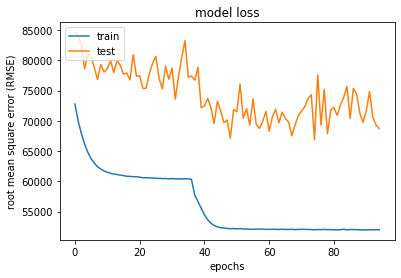

In [ ]:
# Skip first 5 epochs when plotting
plt.plot(train_rmse[5:])
plt.plot(test_rmse[5:])
plt.title('model loss')
plt.ylabel('root mean square error (RMSE)')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
lowest_test_error = min(history.history['val_mse'])
epoch_lowest_error = history.history['val_mse'].index(lowest_test_error) + 1
print("Epoch with lowest test error: \t\t", epoch_lowest_error)
print("Test Mean-squared error at this epoch: \t", lowest_test_error)
print("Test RMSE at this epoch: \t\t", np.sqrt(lowest_test_error))
print("Test R-squared value at this epoch: \t", history.history["val_r_squared"][epoch_lowest_error-1])

Epoch with lowest test error: 		 80
Test Mean-squared error at this epoch: 	 4472199168.0
Test RMSE at this epoch: 		 66874.50312338777
Test R-squared value at this epoch: 	 0.8240652084350586


Epoch with lowest test error: Epoch 80

Test Mean-squared Error at this epoch: 4472199168.0 

Test RMSE at this epoch: 66874.5031

Test R-squared value at this epoch: 0.8241

Compared with the best test RMSE achieved in Q1 of 70045.8364, the model with Embedding layers produced an improved test RMSE of 66874.5031. This improvement in performance is also evident in an increase in R-squared value from 0.8074 to 0.8241. A possible reason for the difference in performance could be that the Embedding layers are able to better learn the instrinsic meaning of each category and envision relationships between categories, instead of treating them as separate categories. For example, in the case of the categorical feature variable "storey_range", the Embedding layer might learn that certain storey ranges are more closely related to each other, such as the higher storey ranges, due to their resale prices are being similarly related as well. This relationship requires a vector representation which cannot be achieved with just one-hot encoding, thus leading to the model with Embedding layers being able to learn the problem better than without.

# QUESTION 3

**3a) Continue with the model architecture you have after Q2. Via a callback,
introduce early stopping (based on val_loss, with patience of 10 epochs) to
the model.**

In [ ]:
# Create callback to introduce early stopping
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1,
)

In [ ]:
# Set parameters
batch_size = 128
no_epochs = 100
lr = 0.05

In [ ]:
# Create array of RFE inputs
RFE_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

In [ ]:
# Create array of RFE input features
RFE_features = [
        flatten_month_emb,
        flatten_fmt_emb,
        flatten_sr_emb,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]

In [ ]:
def decide_feature_to_remove(k, RFE_inputs, RFE_features, control_rmse, control_r_squared):
  """
  Trains models with one input feature removed each time and decides on which feature to remove.

      Parameters: 
          k (int): Integer indicating number of input features to consider removing.
          RFE_inputs (Array): Array containing input features as Keras tensors
          RFE_features (Array): Array containing encoded input features as Dataset objects
          control_rmse (float): RMSE of model trained with all input features to be used for comparison
          control_r_squared (float): R-squared value of model trained with all input features to be used for comparison

      Returns:
          histories_rmse (dict): Dictionary containing lowest RMSE value achieved by each trained model
          histories_r_squared (dict): Dictionary containing highest R-squared value achieved by each trained model
          improvement (dict): Dictionary containing improvement in RMSE and R-squared values compared to control values
  """
  histories_rmse = {}
  histories_r_squared = {}
  improvement = {}

  for i in range(k):

    # Remove one input feature 
    all_inputs = RFE_inputs[:i]
    all_inputs.extend(RFE_inputs[i+1:k])
    all_RFE_features = RFE_features[:i]
    all_RFE_features.extend(RFE_features[i+1:k])
    all_features = layers.concatenate(all_RFE_features)
    print("Testing removal of feature %s from model with %d features:" % (RFE_inputs[i].name, k))

    # Build feedforward network with one hidden layer
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)

    # Initialize optimizer
    opt = keras.optimizers.Adam(learning_rate=lr)

    # Compile model
    model = keras.Model(all_inputs, output)
    model.compile(optimizer=opt, 
                  loss="mse",
                  metrics=["mse", r_squared])
    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
    
    # Train model
    history = model.fit(train_ds,
                        epochs=no_epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[early_stopping_callback],
                        validation_data=val_ds)
    
    # Store results
    histories_rmse[i] = np.sqrt(min(history.history["val_mse"]))
    histories_r_squared[i] = max(history.history["val_r_squared"])
    print("Lowest validation RMSE: ", histories_rmse[i])
    print("Highest validation R-squared: ", histories_r_squared[i])
    improvement[i] = (control_rmse - histories_rmse[i])/control_rmse + histories_r_squared[i] - control_r_squared

  return histories_rmse, histories_r_squared, improvement

### Implement Recursive Feature Elimination

In [ ]:
control_rmse = 66874.50312338777
control_r_squared = 0.8241
dict_of_rmse = {}
stop = False

# Create while loop to continuously remove input features until model performance no longer improves
while stop == False:

  # Decide input feature to remove from model
  print("Training models with %d features." % int(len(RFE_inputs)-1))
  histories_rmse, histories_r_squared, improvement = decide_feature_to_remove(len(RFE_inputs), RFE_inputs, RFE_features, control_rmse, control_r_squared)
  feature_to_remove = max(improvement, key=improvement.get)
  print("Decided to remove %s." % RFE_inputs[feature_to_remove].name)
  
  # Update input feature lists and control metric values
  RFE_inputs.pop(feature_to_remove)
  RFE_features.pop(feature_to_remove)
  control_rmse = histories_rmse[feature_to_remove]
  control_r_squared = histories_r_squared[feature_to_remove]
  dict_of_rmse[len(RFE_inputs)] = histories_rmse
  
  # Clear session every iteration
  backend.clear_session()

  # Stop when there is only 1 feature left
  # Or model performance does not improve from the previous best
  if max(improvement.values()) < 0:
    stop = True
    print("Recursive Feature Elimination terminated as performance no longer improves.")
  if len(RFE_inputs) == 1:
    stop = True
    print("Recursive Feature Elimination terminated as there is only 1 feature left.")

Training models with 8 features.
Testing removal of feature month from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00046: early stopping
Lowest validation RMSE:  62093.57789659088
Highest validation R-squared:  0.8494401574134827
Testing removal of feature flat_model_type from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00038: early stopping
Lowest validation RMSE:  69795.5982566236
Highest validation R-squared:  0.8099430799484253
Testing removal of feature storey_range from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00028: early stopping
Lowest validation RMSE:  71293.09150261334
Highest validation R-squared:  0.8021798133850098
Testing removal of feature floor_area_sqm from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00038: early stopping
Lowest validation RMSE:  64158.17852776059
Highest validation R-squared:  0.8390870690345764
Testing removal of feature remaining_lease_years from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00028: early stopping
Lowest validation RMSE:  70925.15040519829
Highest validation R-squared:  0.8036285042762756
Testing removal of feature degree_centrality from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00044: early stopping
Lowest validation RMSE:  63368.87816586309
Highest validation R-squared:  0.8424187302589417
Testing removal of feature eigenvector_centrality from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00031: early stopping
Lowest validation RMSE:  66593.98747634805
Highest validation R-squared:  0.8265627026557922
Testing removal of feature dist_to_nearest_stn from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00040: early stopping
Lowest validation RMSE:  71051.76118858701
Highest validation R-squared:  0.8026973605155945
Testing removal of feature dist_to_dhoby from model with 9 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00023: early stopping
Lowest validation RMSE:  89012.7095644212
Highest validation R-squared:  0.6917923092842102
Decided to remove month.
Training models with 7 features.
Testing removal of feature flat_model_type from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00029: early stopping
Lowest validation RMSE:  73836.26426086304
Highest validation R-squared:  0.7874690890312195
Testing removal of feature storey_range from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00047: early stopping
Lowest validation RMSE:  69213.02998713465
Highest validation R-squared:  0.812861979007721
Testing removal of feature floor_area_sqm from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00047: early stopping
Lowest validation RMSE:  64967.04001260947
Highest validation R-squared:  0.8348652124404907
Testing removal of feature remaining_lease_years from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00043: early stopping
Lowest validation RMSE:  73926.73908674723
Highest validation R-squared:  0.7864062190055847
Testing removal of feature degree_centrality from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00031: early stopping
Lowest validation RMSE:  62798.440744973916
Highest validation R-squared:  0.8461924195289612
Testing removal of feature eigenvector_centrality from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00047: early stopping
Lowest validation RMSE:  63382.904950783064
Highest validation R-squared:  0.8422335982322693
Testing removal of feature dist_to_nearest_stn from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00058: early stopping
Lowest validation RMSE:  70265.56618999096
Highest validation R-squared:  0.8068646192550659
Testing removal of feature dist_to_dhoby from model with 8 features:


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 00037: early stopping
Lowest validation RMSE:  88976.8732199553
Highest validation R-squared:  0.6923419833183289
Decided to remove degree_centrality.
Recursive Feature Elimination terminated as performance no longer improves.


In [ ]:
# Print table of RMSE values 
rmse_df = pd.DataFrame(dict_of_rmse)
rmse_df.fillna("N.A.", inplace=True)
rmse_df.rename(index={
    0:"Without feature 0",
    1:"Without feature 1",
    2:"Without feature 2",
    3:"Without feature 3",
    4:"Without feature 4",
    5:"Without feature 5",
    6:"Without feature 6",
    7:"Without feature 7",
    8:"Without feature 8"
}, inplace=True)
rmse_df.columns = ["8-feature model", "7-feature model"]
print(rmse_df)

                   8-feature model 7-feature model
Without feature 0     62093.577897         73836.3
Without feature 1     69795.598257           69213
Without feature 2     71293.091503           64967
Without feature 3     64158.178528         73926.7
Without feature 4     70925.150405         62798.4
Without feature 5     63368.878166         63382.9
Without feature 6     66593.987476         70265.6
Without feature 7     71051.761189         88976.9
Without feature 8     89012.709564            N.A.


**2c) Compare the performances of the model with all 9 input features (from Q2) and the best model arrived at by RFE, in terms of both RMSE and R-squared.**

The ideal model returned by the RFE algorithm above was a model with 7 input features, with month and degree_centrality removed. 

Compared to the model with all 9 input features, the model yielded by RFE performed generally better. The lowest test RMSE achieved by the 7-input feature model was 62798.4, which is lower than that of the model with all 9 input features, which was 66874.5. Similarly, the highest test R-squared value of the derived model was 0.8462, which is higher than that of the original model, 0.8241. This indeed helps us conclude that the model performs better when the input features of month and degree_centrality are excluded. 

**2d) By examining the changes in model performance whenever a feature is
removed, evaluate the usefulness of each feature for the task of HDB resale
price prediction.**

Based on the above table of RMSE values, we can rank the performances of each model without a particular feature, across the 2 iterations of RFE which took place.

*month*

Performance of model without month in iteration 1: 9th

Performance of model without month in iteration 2: NA (removed)

*flat_model_type*

Performance of model without flat_model_type in iteration 1: 5th

Performance of model without flat_model_type in iteration 2: 3rd

*storey_range*

Performance of model without storey_range in iteration 1: 2nd

Performance of model without storey_range in iteration 2: 5th

*floor_area_sqm*

Performance of model without floor_area_sqm in iteration 1: 7th

Performance of model without floor_area_sqm in iteration 2: 6th

*remaining_lease_years*

Performance of model without remaining_lease_years in iteration 1: 4th

Performance of model without remaining_lease_years in iteration 2: 2nd

*degree_centrality*

Performance of model without degree_centrality in iteration 1: 8th

Performance of model without degree_centrality in iteration 2: 8th

*eigenvector_centrality*

Performance of model without eigenvector_centrality in iteration 1: 6th

Performance of model without eigenvector_centrality in iteration 2: 7th

*dist_to_nearest_stn*

Performance of model without degree_centrality in iteration 1: 3rd

Performance of model without degree_centrality in iteration 2: 4th

*dist_to_dhoby*

Performance of model without dist_to_dhoby in iteration 1: 1st

Performance of model without dist_to_dhoby in iteration 2: 1st

From the above results, we can infer that dist_to_dhoby is marginally and consistently the most useful feature in HDB resale price prediction. This is followed closely by remaining_lease_years. Meanwhile, month, degree_centrality, eigenvector_centrality and floor_area_sqm can be grouped together as the least useful or relevant features. Then, flat_model_type, storey_range and dist_to_nearest_station can be said to be of moderate usefulness in the prediction task. 



# CONCLUSION

Firstly, comparing results from Questions 1 and 2, we observe that adding an Embedding layer improves the performance of the model, lowering test RMSE and increasing R-squared value. We saw that this could have been due to the ability of Embedding layers to better learn the intrinsic meaning of each category and envision relationships between categories. In order to more closely assess the feasibility of applying Embedding layers to the model  instead of using one-hot encoding, we should also consider the time taken per epoch for either case. This can be done by implementing a callback. Assessing epoch time is essential because the model with embeddings has a higher number of parameters and is hence more complex and computationally expensive to train. It then depends on the application of the model and the resources available, whether it is worth compromising on time to train a model that yields a 0.02 higher R-squared value in terms of accuracy.

Next, in Question 3, we carried out Recursive Feature Elimination (RFE) to rank the importance of the 9 input features used in the model. It was concluded that dist_to_dhoby was the most crucial factor to consider in predicting HDB resale price, while month and degree_centrality stood out as the two features that should be eliminated to improve performance. It was also noteworthy that removing flat_model_type, storey_range, remaining_lease_years, dist_to_nearest_stn and dist_to_dhoby (separately) resulted in an decline in performance from the 9-feature model, suggesting that the consideration of these variables was essential in predicting resale price more accurately. Conversely, for the other 4 features, their removal improved the model's accuracy, indicating that we could build our neural network without them and still obtain better, more efficient results.

When carrying out RFE, one limitation faced was the inconsistency in results. Each time RFE was performed, it resulted in a different set of input features being selected for removal from the model. This suggests that the test RMSE and R-squared values for each input feature must not have been very consistent across all the times the RFE algorithm was run. This could have been due to the method of validation used. The current algorithm above validates the model against the validation dataset, which was obtained via a train test split based on year. To improve the consistency of the RFE algorithm, we could try implementing K-Fold cross-validation instead, as it will give us a closer idea of how the model without a particular input feature will perform on unseen data. 

This would require us to train the control 9-feature model with K-Fold cross-validation as well, so that there is a fair comparison of performance metrics made when deciding when feature to remove. Furthermore, the purpose of carrying out train test split in this task was to ensure the model learns to predict future resale price using historical data. K-Fold cross-validation will be limited in achieving this purpose.

One of the other drawbacks of carrying out RFE is that it is computationally expensive, even with early stopping implemented. 

In order to ensure fewer iterations are needed in RFE, we can carry out a preliminary feature selection for the 6 numerical input features used in this dataset. A correlation heatmap can be visualized for the dataset, enabling us to at a glance see how closely each input feature is individually related to resale price. This also helps us determine whether certain input features have a positive or negative correlation to resale price, which will in turn give us an idea of which factors would lead to an increase in resale price.



# REFERENCES

Lim, W. T., Wang, L., Wang, Y., & Chang, Q. (2016). Housing Price Prediction Using Neural Networks. 12th International Conference on Natural Computation, Fuzzy Systems and Knowledge Discovery.